In [2]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

In [3]:
checkpoint_model_filepath = 'checkpoints/'
trained_model_filepath = 'trained_models/'
training_data_path = 'data_25m/'
nn_config_path = '../config/nn_config.json'
wandb_config_path = '../config/wandb_config.json'

print('Training data path:', training_data_path)

import nn_model

Running on Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data path: /content/drive/MyDrive/DP/training/data_1m/


In [4]:
try:
  with open(wandb_config_path, 'r') as f:
    wandb_config = json.load(f)

  wandb_log = True
  wandb_run_name = wandb_config["wandb_run_name"]
  wandb_group_name = wandb_config["wandb_group_name"]
  wandb_entity = wandb_config["wandb_entity"]
  wandb_project_name = wandb_config["wandb_project_name"]
  if wandb_config["new_model"] == 'false':
    new_model = False
  else:
    new_model = True
  run_name_before = wandb_config["run_name_before"]   # Model to be loaded
  if wandb_config["eval_only"] == 'false':
    eval_only = False
  else:
    eval_only = True

  print('wandb_log:', wandb_log)
  print('wandb_run_name:', wandb_run_name)
  print('wandb_group_name:', wandb_group_name)
  print('wandb_entity:', wandb_entity)
  print('wandb_project_name:', wandb_project_name)
  print('new_model:', new_model)
  print('run_name_before:', run_name_before)
  print('eval_only:', eval_only)

except OSError as e:
  print('\nERROR loading wandb_config file')
  print(e)
  # quit()

wandb_log: True
wandb_run_name: arch4_1m_mi_context_data
wandb_group_name: 1m_deep_dense
wandb_entity: xbarantomik
wandb_project_name: DP
new_model: True
run_name_before: -
eval_only: False


In [5]:
try:
  with open(nn_config_path, 'r') as f:
    nn_config = json.load(f)

  epochs = int(nn_config['epochs'])
  batch_size = int(nn_config['batch_size'])
  patience = int(nn_config['patience'])
  learning_rate = float(nn_config['learning_rate'])
  architecture = int(nn_config['architecture'])
  training_data_file = nn_config['training_data_file'] + '/'

  print('epochs:', epochs)
  print('batch_size:', batch_size)
  print('patience:', patience)
  print('learning_rate:', learning_rate)
  print('architecture:', architecture)
  print('training_data_file:', training_data_file)

except OSError as e:
  print('\nERROR loading nn_config file')
  print(e)
  # quit()

epochs: 25
batch_size: 128
patience: 15
learning_rate: 0.001
architecture: 4
training_data_file: mi_context_data/


#### Load training data

In [6]:
try:
  train_data = np.load(training_data_path + training_data_file + 'train_data.npy')
  val_data = np.load(training_data_path + training_data_file + 'val_data.npy')
  test_data = np.load(training_data_path + training_data_file + 'test_data.npy')
  train_target_ratings = np.load(training_data_path + training_data_file + 'train_target_ratings.npy')
  val_target_ratings = np.load(training_data_path + training_data_file + 'val_target_ratings.npy')
  test_target_ratings = np.load(training_data_path + training_data_file + 'test_target_ratings.npy')

except OSError as e:
  print('\nERROR loading training data')
  print(e)
  quit()

In [9]:
if wandb_log:
  import wandb
  from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

  wandb.login()

  wandb.init(
    config=nn_config,
    entity=wandb_entity,
    project=wandb_project_name,
    name=wandb_run_name,
    group=wandb_group_name
  )

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: xbarantomik. Use `wandb login --relogin` to force relogin


#### NN MODEL

In [10]:
early_stopping = EarlyStopping(patience=patience, monitor='val_loss')

In [12]:
checkpoint_filepath = checkpoint_model_filepath + f"{wandb_run_name}_checkpoint.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True, mode='min', save_weights_only=False, save_format='tf')

if wandb_log:
  callbacks = [early_stopping, checkpoint_callback, WandbMetricsLogger()]

else:
  callbacks = [early_stopping, checkpoint_callback]

#### Create model

In [13]:
if new_model:
  my_model = nn_model.create_model(architecture=architecture, lr=learning_rate, train_data_shape=train_data.shape[1])
  print('\nCreated a new model')
else:
  my_model = load_model(checkpoint_model_filepath + run_name_before + '_checkpoint.h5')
  print('\nLoaded a model')

if my_model != None:
  my_model.summary()
else:
  print('\nERROR loading NN model')
  quit()

Model 4

Created a new model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               10752     
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)       

## Model fitting

In [14]:
if not eval_only:
  print('Training model')
  trained_model = my_model.fit(train_data, train_target_ratings, batch_size, epochs, validation_data=(val_data, val_target_ratings), callbacks=callbacks, verbose=1)
  my_model.save(trained_model_filepath + f"{wandb_run_name}_trained.keras")
else:
  print('Only evaluating model')

Training model
Epoch 1/25
6246/6252 [============================>.] - ETA: 0s - loss: 1.2413 - root_mean_squared_error: 1.1142 - mean_absolute_error: 0.9081

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6252/6252 [==============================] - 28s 4ms/step - loss: 1.2413 - root_mean_squared_error: 1.1142 - mean_absolute_error: 0.9081 - val_loss: 1.1787 - val_root_mean_squared_error: 1.0857 - val_mean_absolute_error: 0.8880
Epoch 2/25
6252/6252 [==============================] - 23s 4ms/step - loss: 1.1929 - root_mean_squared_error: 1.0922 - mean_absolute_error: 0.8914 - val_loss: 1.1704 - val_root_mean_squared_error: 1.0819 - val_mean_absolute_error: 0.8753
Epoch 3/25
6252/6252 [==============================] - 22s 4ms/step - loss: 1.1785 - root_mean_squared_error: 1.0856 - mean_absolute_error: 0.8848 - val_loss: 1.1569 - val_root_mean_squared_error: 1.0756 - val_mean_absolute_error: 0.8774
Epoch 4/25
6252/6252 [==============================] - 22s 4ms/step - loss: 1.1671 - root_mean_squared_error: 1.0803 - mean_absolute_error: 0.8794 - val_loss: 1.1600 - val_root_mean_squared_error: 1.0770 - val_mean_absolute_error: 0.8895
Epoch 5/25
6252/6252 [==============================] -

#### After fitting


----------- Loss chart -----------



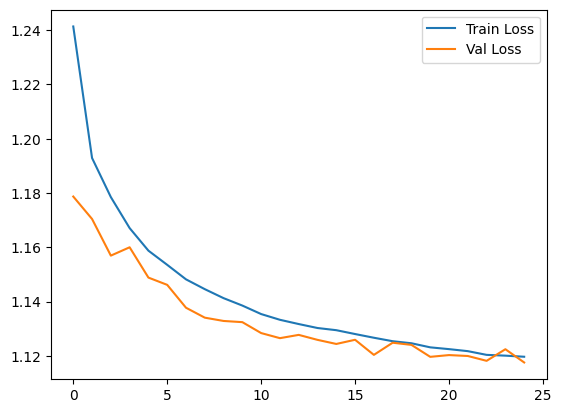


----------- RootMSE chart -----------



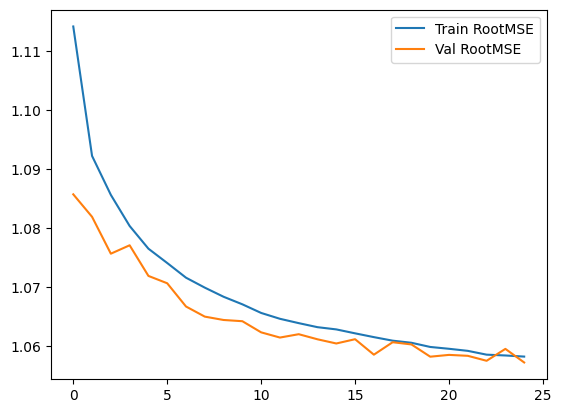


----------- MAE chart -----------



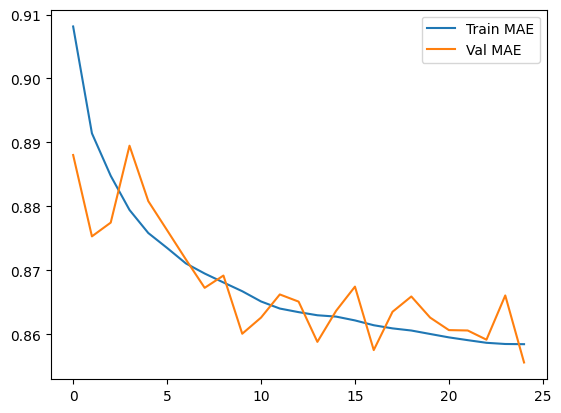

In [15]:
metric_name = ['Loss', 'RootMSE', 'MAE']
train_metric = ['loss', 'root_mean_squared_error', 'mean_absolute_error']
val_metric = ['val_loss', 'val_root_mean_squared_error', 'val_mean_absolute_error']

for i in range(len(metric_name)):

  print(f"\n----------- {metric_name[i]} chart -----------\n")

  # matplotlib chart
  plt.plot(trained_model.history[train_metric[i]], label=f"Train {metric_name[i]}")
  plt.plot(trained_model.history[val_metric[i]], label=f"Val {metric_name[i]}")
  plt.legend()
  plt.show()

In [16]:
# Validation data values in the last epoch
print("number of epochs:", trained_model.epoch[-1] + 1)
print("val_loss:", trained_model.history['val_loss'][-1])
print("val_root_mean_squared_error:", trained_model.history['val_root_mean_squared_error'][-1])
print("val_mean_absolute_error:", trained_model.history['val_mean_absolute_error'][-1])

number of epochs: 25
val_loss: 1.1175919771194458
val_root_mean_squared_error: 1.0571621656417847
val_mean_absolute_error: 0.8555500507354736


In [17]:
# Evaluate the model on the test data
print("Evaluate on test data")
test_loss, test_mean_squared_error, test_mean_absolute_error = my_model.evaluate(test_data, test_target_ratings)
print("Test_loss:", test_loss)
print("Test_root_mean_squared_error:", test_mean_squared_error)
print("Test_mean_absolute_error:", test_mean_absolute_error)
print('\n')

print("Generate predictions for 10 samples")
predictions = my_model.predict(test_data)
test_y_comparison = pd.DataFrame({'test_y_true': test_target_ratings, 'test_y_pred': [x for x in predictions]})

print(test_y_comparison.head(10))

Evaluate on test data
3126/3126 [==============================] - 6s 2ms/step - loss: 1.1219 - root_mean_squared_error: 1.0592 - mean_absolute_error: 0.8572
Test_loss: 1.1218910217285156
Test_root_mean_squared_error: 1.0591936111450195
Test_mean_absolute_error: 0.857182502746582


Generate predictions for 10 samples
3126/3126 [==============================] - 4s 1ms/step
   test_y_true  test_y_pred
0            4  [3.7532423]
1            3  [2.3813221]
2            5   [3.461492]
3            5  [3.6709225]
4            4   [3.633793]
5            4  [3.5628154]
6            4  [4.2777843]
7            3  [4.0491004]
8            1   [3.434622]
9            5  [3.9943929]


In [18]:
if wandb_log:
  wandb.finish()

epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/mean_absolute_error,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/root_mean_squared_error,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▆▆▅▄▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁
epoch/val_mean_absolute_error,█▅▆█▆▅▄▃▄▂▂▃▃▂▃▃▁▃▃▂▂▂▂▃▁
epoch/val_root_mean_squared_error,█▇▆▆▅▄▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁
epoch/epoch,24
epoch/learning_rate,0.001
epoch/loss,1.1197
